# Hierarchical Linear Model for US Presidential Election Predictions using Probalistic Programming

In [1]:
from final_2016 import pass_data

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import copy
from scipy.special import logit
from scipy.special import expit
from torch import cholesky

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

from pyro.infer import Predictive
from pyro.infer import MCMC, NUTS

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from matplotlib import pyplot
from statsmodels.graphics.regressionplots import abline_plot


NaN = float('nan')

## Hierarchical Linear Model

Our goals are two-fold:
    1. is to translate The Economist's presidential election prediction model from R & Stan to Python & Pyro
    2. is to do a thorough evaluation of the results generated by the model and inference methods we have translated from the previous goal

In [3]:
# Creation of a covariance matrix of size (n, n) with variance sigma2 
def cov_matrix(n, sigma2, rho):
        m = np.ones(shape=(n,n)) * rho
        m2 = np.zeros(shape=(n,n))

        np.fill_diagonal(m, 1)
        np.fill_diagonal(m2, sigma2 ** .5) 
    
        return(np.matmul(np.matmul(m2, m), m2))

def check_cov_matrix(mat, weights):
        diag = np.diag(mat)

# Fitting RMSE linear regression with hardcoded param values & hyper param values
def fit_rmse_day_x(x):
        y = []
        for num in x:
                y.append( 0.03 + (10 **(-6.6)) * (num ** 2) )
        return y

## Model

The model that we have translated is a Dynamic Bayesian Model which is a bayesian network that relates the latent variables amongst themselves over adjacent time steps. The model has a backward component categorized by $y^d_i \sim \text{Binom}(n_i, \pi^d_{i,j})$, where $y^d_i$ is the number of voters in favor of a democrat, $n_i$ is the number of voters reporting a party preference, and $\pi^d_{i,j}$ is the share who would vote for democratic candidate on day $j$. The prior is $\pi^d_{i,j} = \text{logit}^{-1}(\beta_{i,j} + \delta_j)$ where $\beta_{i,j}$ is the state level effect and $\delta_j$ is the national level effect with priors defined on both of these R.V. as well. 

#### Abramovitz "Time for Change" Model

national_mu_prior = $x_0 + x_1 \cdot \text{juneapp} + x_2 \cdot \text{q2gdp}$

In [4]:
data, polls, res, dfTemp, ev_state = pass_data()

                            OLS Regression Results                            
Dep. Variable:                incvote   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     25.15
Date:                Sat, 28 Nov 2020   Prob (F-statistic):           1.62e-05
Time:                        02:47:40   Log-Likelihood:                -41.736
No. Observations:                  18   AIC:                             89.47
Df Residuals:                      15   BIC:                             92.14
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.6070      0.835     59.386      0.0

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


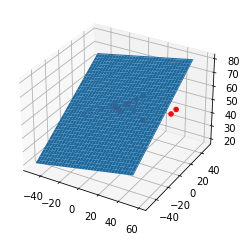

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfTemp['juneapp'], dfTemp['q2gdp'], dfTemp['incvote'], c='r', marker='o')

coefs = res.params
xs = np.tile(np.arange(101), (101,1)) - 50
ys = np.tile(np.arange(101), (101,1)).T - 50
national_mu_prior =  coefs["Intercept"] + coefs["juneapp"] * xs + coefs["q2gdp"] * ys

ax.plot_surface(xs,ys,national_mu_prior)
plt.show()

## Model

In [6]:
from poll_model import model

In [7]:
# MCMC with No-U Turn Sampler
def Inference_MCMC(model, data, polls, n_samples = 500, n_warmup = 500, n_chains = 1):
    nuts_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True, max_tree_depth = 6)
    mcmc = MCMC(nuts_kernel, num_samples = n_samples, warmup_steps = n_warmup, num_chains = n_chains)
    mcmc.run(data, polls)
    
    # the samples that were not rejected; actual samples from the posterior dist
    posterior_samples = mcmc.get_samples()

    # turning to a dict
    hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

    return posterior_samples, hmc_samples

In [8]:
#Generate samples from posterior predictive distribution
def sample_posterior_predictive(model, posterior_samples, n_samples, data):
    posterior_predictive = Predictive(model, posterior_samples, num_samples = n_samples)(data, polls = None)

    return posterior_predictive

In [9]:
#Generating Quantity from posterior sample
def predicted_score(posterior_predictive):
    T = data['T']
    S = data['S']
    predicted = torch.empty(T, S)
    mu_b = posterior_predictive["mu_b"].squeeze().mean(axis=0)
    for s in range(S):
        predicted[:,s] = expit(mu_b[s,:])

    return predicted



### Here we are using the pass_data( ) function from our final_2016.py helper python file in order to abstract the extensive & dull data preprocessing needed before feeding into the model

In [10]:
posterior_samples, hmc_samples = Inference_MCMC(model, data, polls, 5, 5)

Sample: 100%|██████████| 10/10 [01:20,  8.08s/it, step size=2.30e-02, acc. prob=0.921]


In [11]:
posterior_samples.keys()

dict_keys(['raw_mu_b_T', 'raw_mu_b', 'raw_mu_c', 'raw_mu_m', 'raw_mu_pop', 'mu_e_bias', 'rho_e_bias', 'raw_e_bias', 'measure_noise_national', 'measure_noise_state', 'raw_polling_bias'])

In [12]:
posterior_predictive = sample_posterior_predictive(model, posterior_samples, 100, data)
posterior_predictive.keys()

/Users/manik/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyro/infer/predictive.py:148: UserWarning: Sample's leading dimension size 5 is different from the provided 100 num_samples argument. Defaulting to 5.
  warnings.warn("Sample's leading dimension size {} is different from the "


dict_keys(['n_democrat_state', 'n_democrat_national', 'mu_b', 'mu_c', 'mu_m', 'mu_pop', 'sigma_rho', 'e_bias', 'polling_bias', 'national_mu_b_average', 'national_polling_bias_average', 'logit_pi_democrat_state', 'logit_pi_democrat_national'])

In [ ]:
import dill

with open('posterior.pkl', 'wb') as f:
    dill.dump(posterior_samples, f)
with open('predictive.pkl', 'wb') as f:
    dill.dump(posterior_predictive, f)

In [13]:
predicted = predicted_score(posterior_predictive)
predicted

tensor([[0.4810, 0.4315, 0.4806,  ..., 0.5028, 0.4962, 0.3051],
        [0.4810, 0.4302, 0.4804,  ..., 0.5029, 0.4961, 0.3046],
        [0.4807, 0.4312, 0.4806,  ..., 0.5032, 0.4965, 0.3047],
        ...,
        [0.4306, 0.4237, 0.4581,  ..., 0.4389, 0.4956, 0.2815],
        [0.4308, 0.4244, 0.4592,  ..., 0.4378, 0.4969, 0.2823],
        [0.4306, 0.4254, 0.4596,  ..., 0.4378, 0.4977, 0.2828]])

In [14]:
predicted.shape

torch.Size([252, 51])

In [15]:
vals = posterior_predictive['mu_b'][:].squeeze().mean(axis=0)

In [16]:
print(len(predicted))
print(len(predicted[0]))

252
51


In [17]:
from collections import defaultdict

# ~~~ example ~~~~
#plot next to the prior distribution to see if there is some sort of improvement 

preds = defaultdict(list)
for i in range(len(predicted)):
    temp = predicted[i]
    for j in range(len(temp)):
        preds[j].append(temp[j])

In [18]:
EV_Index = {0:"AL", 1:"AK", 2:"AZ", 3:"AK", 4:"CA", 5:"CO", 6:"CT", 7: "DC", 8:"DE", 9:"FL", 10:"GA", 11:"HI", 
    12:"ID", 13:"IL", 14:"IN", 15:"IA", 16:"KS", 17:"KY", 18:"LA", 19:"ME", 20:"MD", 21:"MA", 22:"MI", 23:"MN",
    24:"MS", 25:"MO", 26:"MT", 27:"NE", 28:"NV", 29:"NH", 30:"NJ", 31:"NM", 32:"NY", 33:"NC", 34:"ND", 
    35:"OH", 36:"OK", 37:"OR", 38:"PA", 39:"RI", 40:"SC", 41:"SD", 42:"TN", 43:"TX", 44:"UT", 45:"VT", 
    46:"VA", 47:"WA", 48:"WV", 49:"WI", 50:"WY",} 

EV = {"AK": 9, "AL": 13, "AZ": 11, "AK": 6, "CA": 55, "CO":9, "CT": 7, "DE": 3, "FL": 29, "GA": 16, "HI": 4, 
    "ID": 4, "IL": 20, "IN": 11, "IA": 6, "KS": 6, "KY": 8, "LA": 8, "ME": 4, "MD": 10, "MA": 11, "MI": 16, "MN": 10,
    "MS": 6, "MO": 10, "MT": 3, "NE": 5, "NV": 6, "NH": 4, "NJ": 14, "NM": 5, "NY": 29, "NC": 15, "ND": 3, 
    "OH": 18, "OK": 7, "OR": 7, "PA": 20, "RI": 4, "SC": 9, "SD": 3, "TN": 11, "TX": 38, "UT": 6, "VT": 3, 
    "VA": 13, "WA": 12, "WV": 5, "WI": 10, "WY": 3, "DC": 3}

In [19]:
numDays = len(preds[0])
numStates = len(preds)


clintonWins = 0
trumpWins = 0
for i in range(numDays):
    evTotal = 0
    evTotal2 = 0
    wl = []
    ll = []
    for j in range(numStates):
        pct = preds[j][i]
        if pct >= 0.5:
            wl.append(EV_Index[j])
            evTotal += EV[EV_Index[j]]
        else:
            ll.append(EV_Index[j])
            evTotal2 += EV[EV_Index[j]]
    evTotal = int(evTotal)
    evTotal2 = int(evTotal2)
    if evTotal > evTotal2:
        clintonWins += 1
    else:
        trumpWins += 1
    print("EV: ", evTotal, evTotal2)
    print('wl', wl)
    print('ll', ll)
print(clintonWins, trumpWins)   

EV:  356 189
wl ['CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'HI', 'IL', 'IN', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WV']
ll ['AL', 'AK', 'AZ', 'AK', 'GA', 'ID', 'KS', 'KY', 'LA', 'MS', 'MO', 'MT', 'NE', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WI', 'WY']
EV:  356 189
wl ['CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'HI', 'IL', 'IN', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WV']
ll ['AL', 'AK', 'AZ', 'AK', 'GA', 'ID', 'KS', 'KY', 'LA', 'MS', 'MO', 'MT', 'NE', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WI', 'WY']
EV:  356 189
wl ['CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'HI', 'IL', 'IN', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WV']
ll ['AL', 'AK', 'AZ', 'AK', 'GA', 'ID', 'KS', 'KY', 'LA', 'MS', 'MO', 'MT', 'NE', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WI', 'WY']
EV:  356 189
wl ['C

EV:  322 223
wl ['CA', 'CO', 'CT', 'DC', 'DE', 'HI', 'IL', 'IN', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA']
ll ['AL', 'AK', 'AZ', 'AK', 'FL', 'GA', 'ID', 'KS', 'KY', 'LA', 'MS', 'MO', 'MT', 'NE', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WV', 'WI', 'WY']
EV:  322 223
wl ['CA', 'CO', 'CT', 'DC', 'DE', 'HI', 'IL', 'IN', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA']
ll ['AL', 'AK', 'AZ', 'AK', 'FL', 'GA', 'ID', 'KS', 'KY', 'LA', 'MS', 'MO', 'MT', 'NE', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WV', 'WI', 'WY']
EV:  322 223
wl ['CA', 'CO', 'CT', 'DC', 'DE', 'HI', 'IL', 'IN', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA']
ll ['AL', 'AK', 'AZ', 'AK', 'FL', 'GA', 'ID', 'KS', 'KY', 'LA', 'MS', 'MO', 'MT', 'NE', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WV', 'WI', 'WY']
EV:  322 223
wl ['C

## Graphs and Plots

In [20]:
import plotnine as p9
from plotnine import *

In [21]:
import dill

with open('posterior.pkl', 'rb') as f:
    posterior_samples = dill.load(f)
with open('predictive.pkl', 'rb') as f:
    posterior_predictive = dill.load(f)

In [22]:
def mean_low_high(draws, states, Id):
    mean = expit(draws.mean(axis=0))
    high = expit(draws.mean(axis=0) + 1.96* draws.std(axis = 0))
    low = expit(draws.mean(axis=0) - 1.96* draws.std(axis = 0))
    Id = [Id]*len(states)
    draws_df = {'states': states ,'mean': mean, 'high': high, 'low': low, 'type': Id}
    draws_df = pd.DataFrame(draws_df)
    
    return draws_df

In [23]:
states = list(ev_state.keys())

In [24]:
mu_b_prior = data['mu_b_prior']
state_covariance_mu_b_T = data['state_covariance_mu_b_T']
mu_b_prior_draws = np.random.multivariate_normal(mu_b_prior, state_covariance_mu_b_T, 1000)
mu_b_prior_df = mean_low_high(mu_b_prior_draws, states, 'prior')

In [25]:
mu_b_posterior_draws = posterior_predictive['mu_b'].squeeze()[:,:,538]
mu_b_posterior_df = mean_low_high(mu_b_posterior_draws, states, 'posterior')
mu_b_posterior_df['color'] = mu_b_posterior_df['mean']>0.5
mu_b_posterior_df[['states', 'mean', 'high', 'low']]

,states,mean,high,low
0,AL,0.372810,0.372827,0.372793
1,AK,0.411667,0.411687,0.411647
2,AZ,0.438596,0.438616,0.438575
3,AR,0.363455,0.363472,0.363438
4,CA,0.603668,0.603689,0.603647
5,CO,0.512329,0.512348,0.512311
6,CT,0.572605,0.572623,0.572587
7,DC,0.912164,0.912173,0.912154
8,DE,0.579363,0.579379,0.579346
9,FL,0.489257,0.489275,0.489238


In [26]:
mu_b_df = pd.concat([mu_b_prior_df, mu_b_posterior_df])

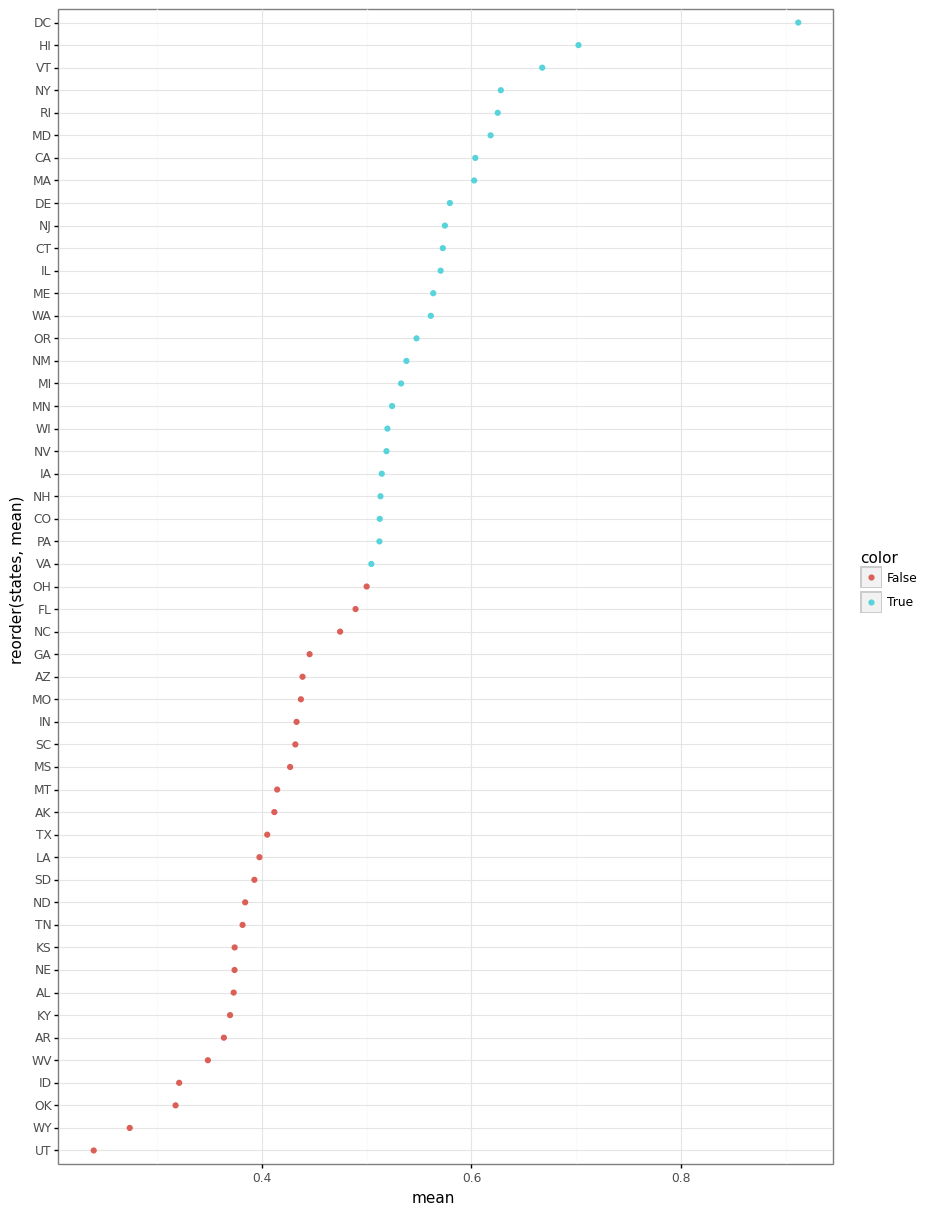

<ggplot: (335075985)>

In [27]:
p9.options.figure_size = (10, 15)
(
    ggplot(mu_b_posterior_df) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='color'), position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()
 )

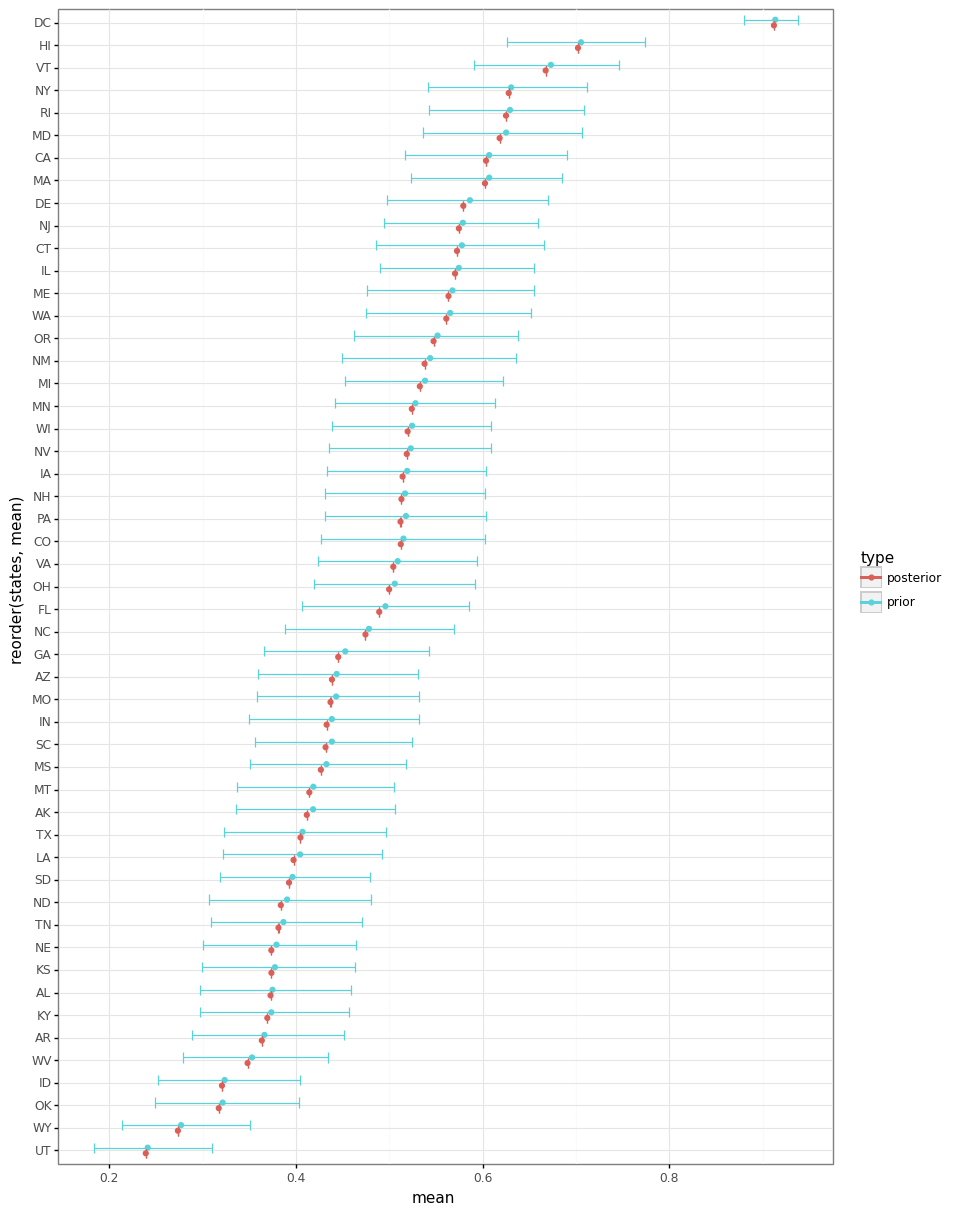

<ggplot: (335182921)>

In [28]:
p9.options.figure_size = (10, 15)
(
    ggplot(mu_b_df) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='type'), position = position_dodge(width = 0.5)) +
    geom_errorbar(aes(ymin = 'low', ymax = 'high', x = 'states', color='type'), width = 0, position = position_dodge(width = 0.5)) +
    coord_flip() +
    theme_bw()
 )

In [29]:
cols = ['state', 'year', 'dem']
results = pd.read_csv("../../data/potus_results_76_16.csv", usecols=cols)
results = results.loc[results['year'] == 2016][['state','dem']].reset_index().drop(columns=['index'])
results = results.rename(columns={'state': 'states', 'dem':'mean'})
results['type'] = ['result']*len(states)

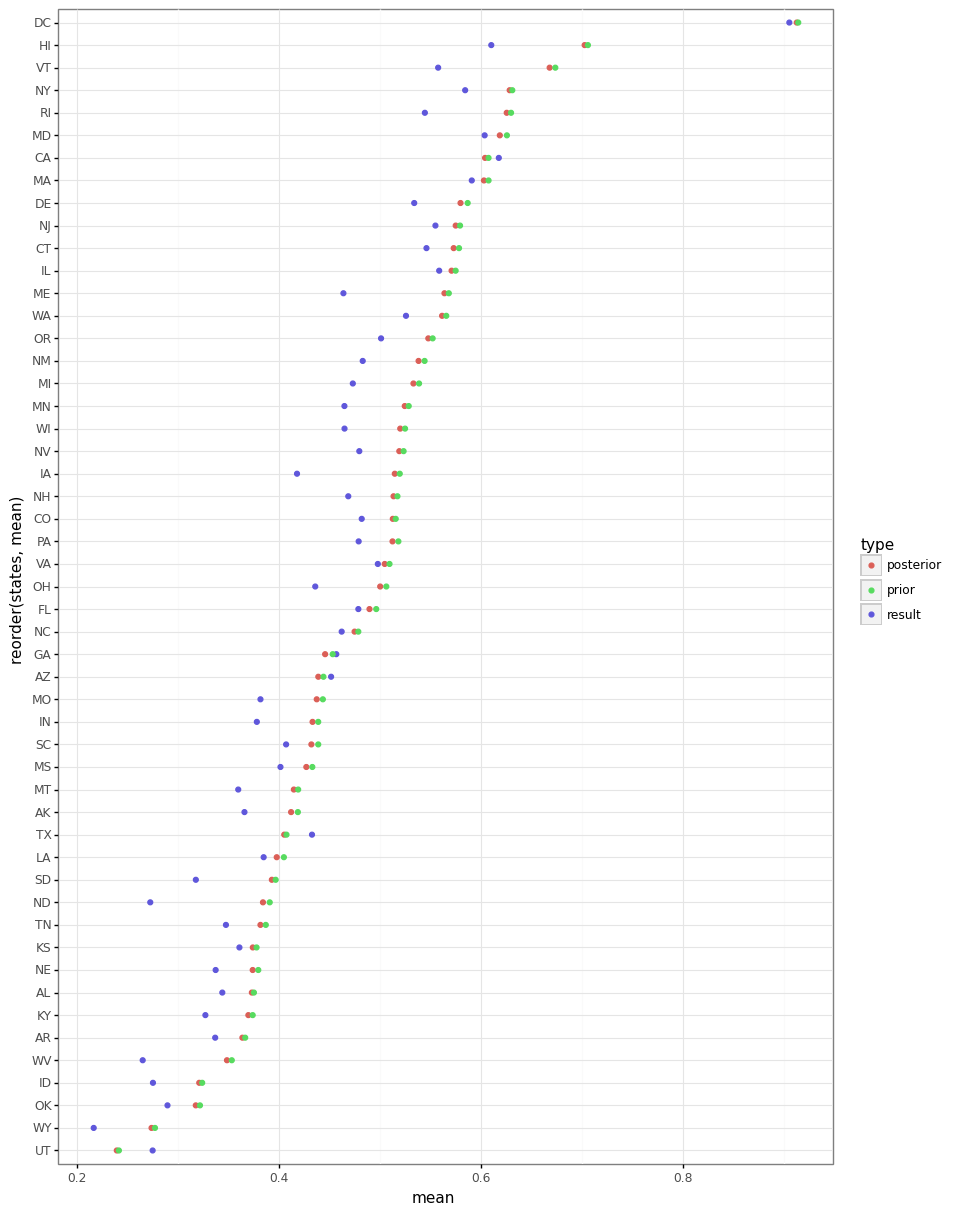

<ggplot: (335357543)>

In [30]:
p9.options.figure_size = (10, 15)
(
    ggplot(pd.concat([results, mu_b_posterior_df, mu_b_prior_df])) +
    geom_point(aes(y = 'mean', x = 'reorder(states, mean)', color='type')) +
    coord_flip() +
    theme_bw()
 )